In [1]:
%load_ext autoreload
%autoreload 2

# Classification Models
The purpose of this notebook is to train classification models of different types. The main commonality is the classification architecture. The difference is which dataset is being used. 

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as transforms
import torch
from torchsummary import summary
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Classify import classification_cnn
import confusion_matrix as cm

# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Set hyperparameters
|Name|Description/Options|
|---: |:----------------|
|method | Method used for classification. Direct encoded images or decoded images. `direct` or `decoder` |
|SNR| Signal to noise ratio. noiseless, 30dB, 20dB, 10dB, 5dB, 1dB|
|dataset_name| CIFAR10 or MNIST|
|dataset|Long name of dataset. Usually something like: {dataset_name}\_mura\_{SNR}\ + \_reconstructed\_{method}\_method|
|image_size| Size of encoded images|
|suffix| suffix for classfication model. Usually {dataset_name}\_{SNR}\ + \_reconstructed\_{method}\_method|
|batch_size| Number of samples in one batch|
|classes|labels for dataset|

In [6]:
# Define method, SNR and dataset
method = 'direct' 
SNR = 'noiseless' 
dataset_name = 'CIFAR10'

# Create dict to log into WandB
params = {
  "dataset": f"{dataset_name}_mura_gray",#f"CIFAR10_mura_{SNR}_reconstructed_{method}_method",
  "image_size": 23,
  "SNR": SNR,
  "method": method,
  "suffix": f"{dataset_name}_encoded",#f"CIFAR10_{SNR}_reconstructed_{method}_method",#f"CIFAR10_{SNR}",#f"{SNR}_reconstructed_{method}_method",#f"{SNR}dB" #_reconstructed_{method}_method",
  "batch_size":100,
  "classes": ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') if dataset_name.upper() == "CIFAR10" else [i for i in range(10)]
}

print(f"The dataset loaded will be : {params['dataset']}")

The dataset loaded will be : CIFAR10_mura_gray


# Load MNIST Data

In [4]:
# ---------- Define Model, Loss, and Optimizer ----------
model = classification_cnn(params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) 
wandb.config = model.params
print(model.params['model'])

classification_CIFAR10_encoded


In [5]:
%time
# Get clean data for baseline test
# train_data, eval_data, test_data, loaders = model._get_clean_dataset(model.params)

# Get encoded data 
train_data, eval_data, test_data, loaders = classification_cnn.load_encoded_data(model.params)

CPU times: user 4 µs, sys: 9 µs, total: 13 µs
Wall time: 17.2 µs
Loading dataset from: ../data/CIFAR10/training_CIFAR10_mura_gray


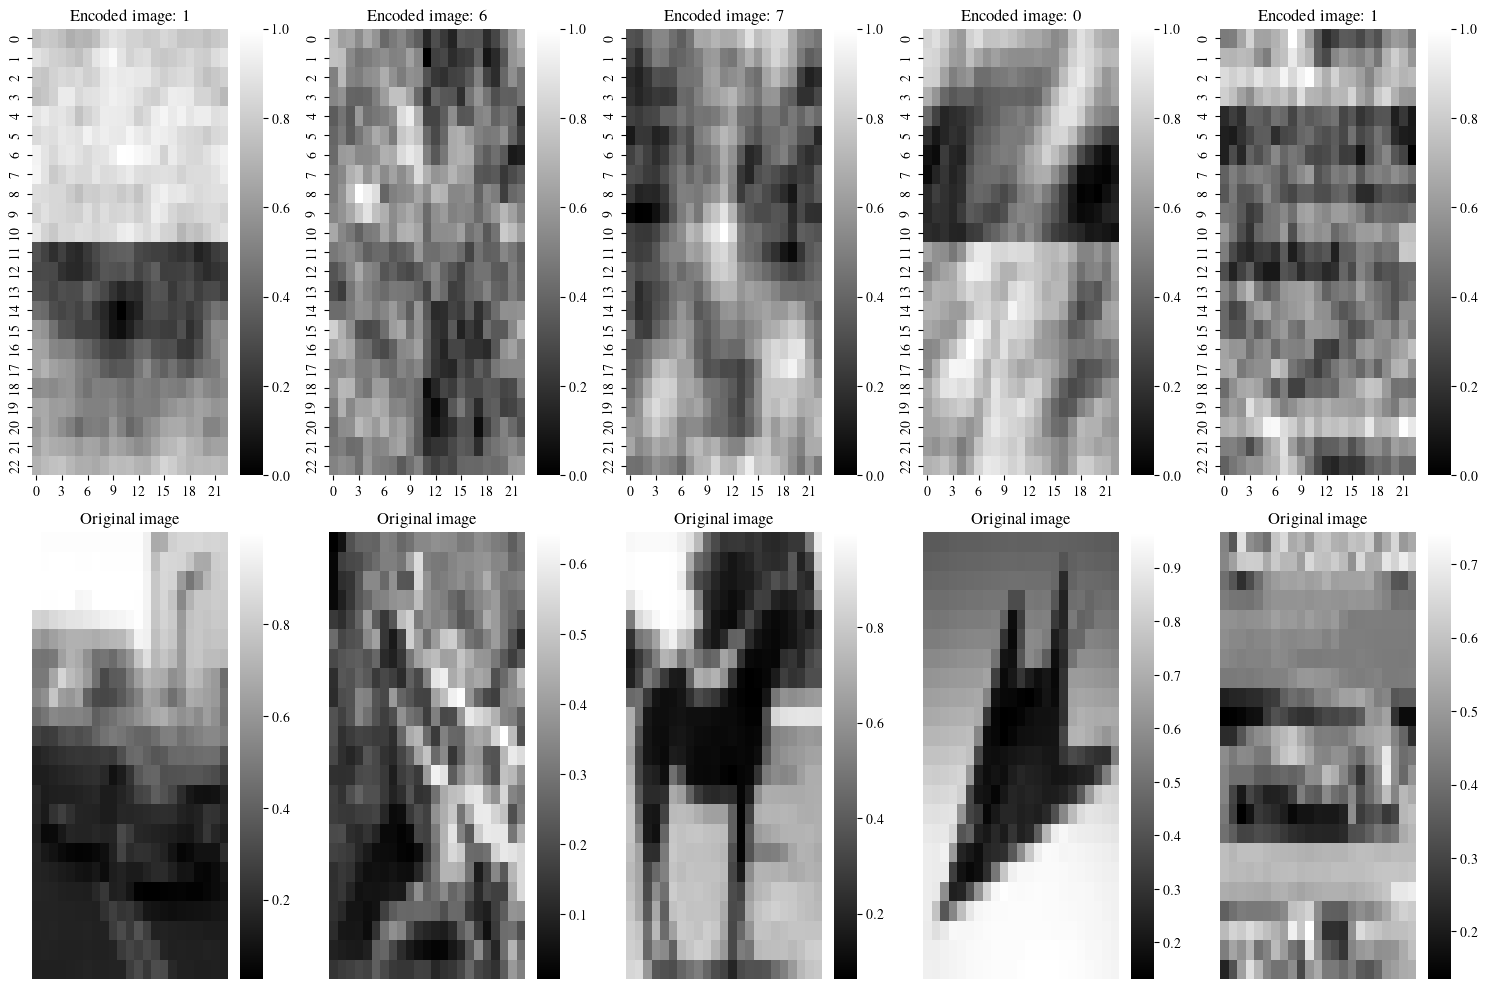

In [6]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(train_data[idx][0].squeeze(), cmap='gray')
    plt.title(f'Encoded image: {train_data[idx][2]}')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(train_data[idx][1].squeeze(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

## Train

In [7]:
%%time
# -------------------------------- TRAIN --------------------------------
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, 
           project="coded-aperture-CIFAR10", 
           group=model.params["kind"], 
           name=f"{model.params['model']}")

# Store values for later 
train_loss = []
val_loss = []

print("Starting training...")
# Start training
for epoch in range(model.params['epochs']):
    # --------------------- Training ------------------
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loaders['train']):
        
        if len(data) == 3:
            # Train encoded images
            img_batch, _, digit_batch = data
        elif len(data) == 4:
            # Train encoded images with noise
            # get the inputs; data is a list of [encoded image, original image, digit label, noise level]
            img_batch, _, digit_batch, _ = data
        else:
            # Train clean images for baseline model
            img_batch, digit_batch = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(img_batch)
        loss = criterion(outputs, digit_batch)
        loss.backward()
        optimizer.step()
    

        running_loss += loss.item()
        
    # Average loss over entire dataset
    running_loss /= len(loaders['train'].dataset)
    train_loss.append(running_loss)
    
    # --------------------- Validation ------------------
    model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(loaders['eval']):
            if len(vdata) == 3:
                # Train encoded images
                vinputs, _, vdigits = vdata
            elif len(vdata) == 4:
                # Train encoded images with noise
                # get the inputs; data is a list of [encoded image, original image, digit label, noise level]
                vinputs, _, vdigits, _ = vdata
            else:
                # Train clean images for baseline model
                vinputs, vdigits = vdata
            # # vinputs, _, vdigits, _ = vdata
            # vinputs, _, vdigits = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vdigits)
            running_vloss += vloss
        running_vloss/= len(loaders['eval'].dataset)
        val_loss.append(running_vloss) 
        
    print(f"Epoch {epoch +1} | Loss: {running_loss:.7f} | Val_loss: {running_vloss:.7f}")
    wandb.log({"epoch": epoch, "loss": running_loss, "val_loss": running_vloss})
print('Finished Training')

# Save model
wandb.finish()
print(f"Model will be saved in {model.params['model_save_path']}")
torch.save(model.state_dict(), model.params['model_save_path'])
print("Model saved")

Starting training...
Epoch 1 | Loss: 0.0211970 | Val_loss: 0.0197731
Epoch 2 | Loss: 0.0191929 | Val_loss: 0.0184069
Epoch 3 | Loss: 0.0181743 | Val_loss: 0.0178391
Epoch 4 | Loss: 0.0173529 | Val_loss: 0.0174439
Epoch 5 | Loss: 0.0167332 | Val_loss: 0.0165263
Epoch 6 | Loss: 0.0162630 | Val_loss: 0.0161493
Epoch 7 | Loss: 0.0158140 | Val_loss: 0.0162081
Epoch 8 | Loss: 0.0155053 | Val_loss: 0.0159691
Epoch 9 | Loss: 0.0151618 | Val_loss: 0.0156749
Epoch 10 | Loss: 0.0148051 | Val_loss: 0.0156667
Epoch 11 | Loss: 0.0144966 | Val_loss: 0.0156677
Epoch 12 | Loss: 0.0142071 | Val_loss: 0.0154945
Epoch 13 | Loss: 0.0139695 | Val_loss: 0.0155575
Epoch 14 | Loss: 0.0136340 | Val_loss: 0.0153893
Epoch 15 | Loss: 0.0133468 | Val_loss: 0.0154632
Epoch 16 | Loss: 0.0130610 | Val_loss: 0.0161101
Epoch 17 | Loss: 0.0127775 | Val_loss: 0.0155672
Epoch 18 | Loss: 0.0125577 | Val_loss: 0.0158522
Epoch 19 | Loss: 0.0122073 | Val_loss: 0.0161054
Epoch 20 | Loss: 0.0119300 | Val_loss: 0.0159819
Epoch 21

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇█
epoch,49
loss,0.00405
val_loss,0.03377


Model will be saved in ../models/classification/CIFAR10/classification_CIFAR10_encoded.pth
Model saved
CPU times: user 8min 54s, sys: 47.9 s, total: 9min 41s
Wall time: 7min 21s


In [8]:
#----------------------------- Save The Losses -----------------------------
import pickle
with open(path+f'metrics/{model.params["kind"]}/train_loss_{model.params["model"]}.pkl','wb') as fp:
    pickle.dump(train_loss, fp)
with open(path+f'metrics/{model.params["kind"]}/validation_train_loss_{model.params["model"]}.pkl','wb') as fp:
    pickle.dump(val_loss, fp)

## Evaluate

In [ ]:
# Load model if one is not loaded already
model.load_state_dict(torch.load(model.params['model_save_path']))

### ALL test set

In [9]:
#----------------------------- Evaluate Test set -----------------------------

# Initialize variables
correct = 0
total = 0
incorrect_examples = []
predicted_all = []
labels_all = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        if len(data) == 3:
            # encoded images, original images, labels
            images, original_images, labels = data
        elif len(data) == 4:
            # encoded images, original images, labels, noise level
            images, original_images, labels, _ = data
        else:
            images, labels = data
            original_images = images
        # calculate outputs by running images through the network (done in batches)
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Save misclassifications
        idxs_mask = torch.nonzero(predicted != labels) #((predicted == labels) == False).nonzero()
        for single_sample in idxs_mask:
            incorrect_examples.append([np.squeeze(images[single_sample].numpy()), 
                                       original_images[single_sample].numpy(),
                                       labels[single_sample].numpy()[0], 
                                       predicted[single_sample].numpy()[0]])
        predicted_all.append(predicted.tolist())
        labels_all.append(labels.tolist())

print(f'Accuracy of the model {model.params["model"]} on the {total} test images: {100 * correct / total} %')

predicted_all = list(np.concatenate(predicted_all).flat) 
labels_all = list(np.concatenate(labels_all).flat) 

Accuracy of the model classification_CIFAR10_encoded on the 6000 test images: 40.3 %


## Confusion Matrix

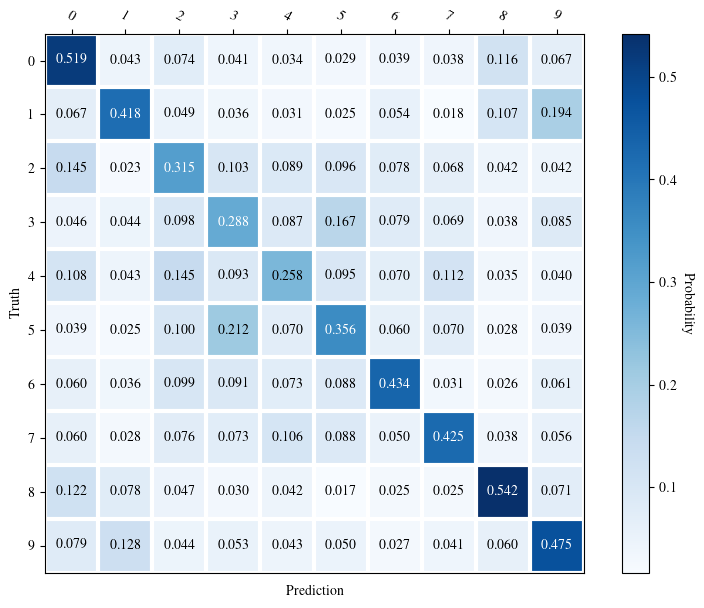

In [10]:
## Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
#fig1.savefig("../figs/conf_mat.png")

## Class-specific accuracy

In [87]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        images, _, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.3f} %')

ValueError: not enough values to unpack (expected 3, got 2)

# Missclassifications

In [22]:
#index = 1
FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"

cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    img = np.squeeze(incorrect_examples[index][0])
    # true_img = incorrect_examples[index][1]#mura.FFT_convolve(img, params[''])
    true_lab = incorrect_examples[index][2]
    pred_lab = incorrect_examples[index][3]

    if true_lab in [5,7,3,8,9]:
        #fig, axs = plt.subplots(2,1, figsize=(5,12))
        #axs = axs.ravel()
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs[0].imshow(true_img, cmap=cmap)
        axs.imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[0].set_title(f"Original Image", fontsize=24)
        # fig.savefig(FIG_FOLDER + f"misclass_encoded_{index}.png")
        plt.show() 

IndexError: list index out of range

In [11]:
# Save dataframe with misclassifications
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'original_image','label', 'prediction'])
df.head()

,image_array,original_image,label,prediction
0,"[[0.9031616, 0.9483998, 0.9185314, 0.7648084, ...",[[[[0.564533 0.5405539 0.5608446 0.5616067...,8,7
1,"[[0.71999335, 0.6591724, 0.5459032, 0.5536922,...",[[[[0.25906372 0.13606292 0.05722088 0.0910036...,2,3
2,"[[0.5189862, 0.561141, 0.51119846, 0.62776875,...",[[[[0.87607574 0.8917254 0.8728036 0.8738174...,4,8
3,"[[0.6169808, 0.49487337, 0.42427146, 0.4012307...",[[[[0.77308047 0.77424335 0.7814723 0.7925781...,2,4
4,"[[0.41378126, 0.30632326, 0.38393322, 0.452803...",[[[[0.44247967 0.25706553 0.43063313 0.7728234...,0,3


In [12]:
df.label.value_counts(normalize=True)

4    0.124232
3    0.121441
5    0.109994
2    0.109715
1    0.098827
7    0.096873
6    0.095477
9    0.085706
0    0.082077
8    0.075656
Name: label, dtype: float64

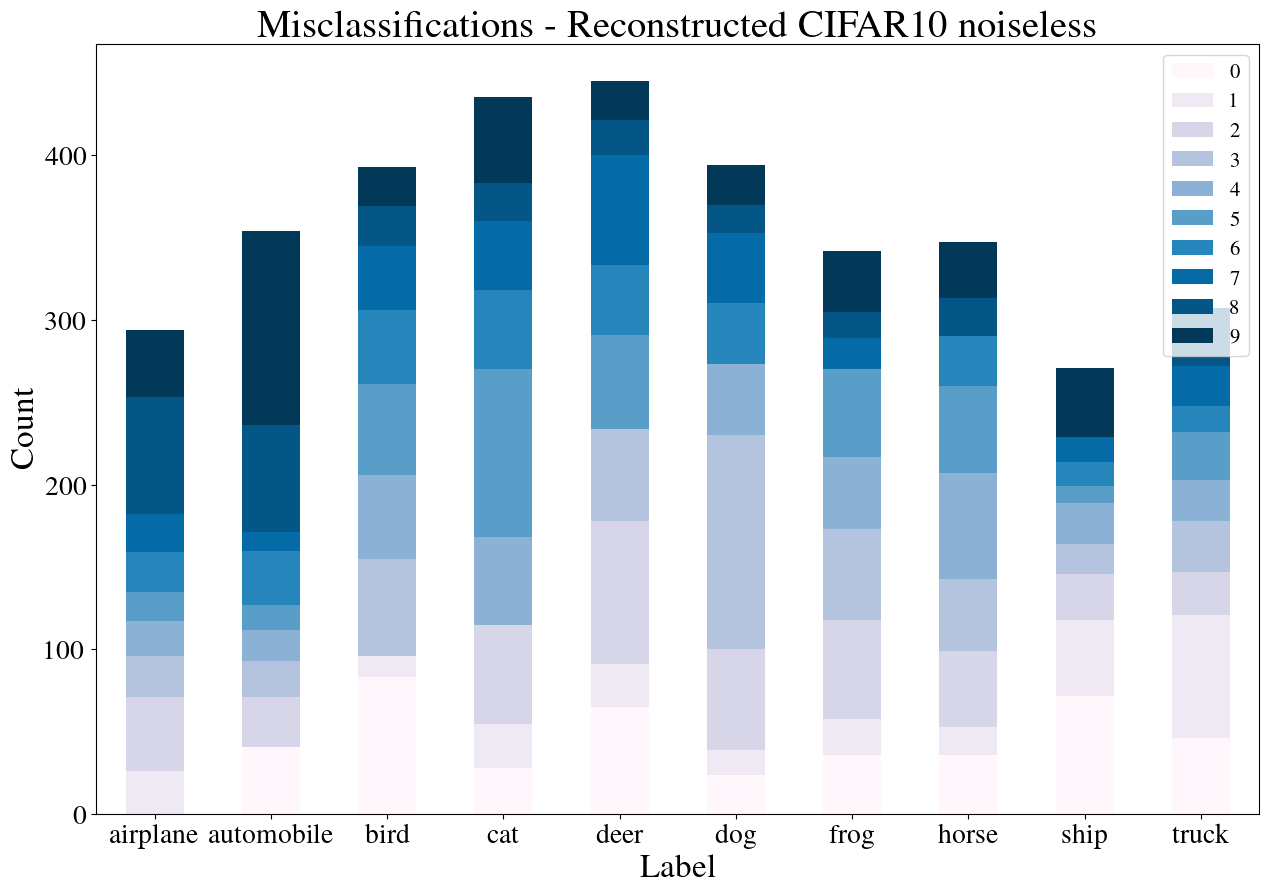

prediction   0   1   2    3   4    5   6   7   8    9
label                                                
0            0  26  45   25  21   18  24  23  71   41
1           41   0  30   22  19   15  33  11  65  118
2           83  13   0   59  51   55  45  39  24   24
3           28  27  60    0  53  102  48  42  23   52
4           65  26  87   56   0   57  42  67  21   24
5           24  15  61  130  43    0  37  43  17   24
6           36  22  60   55  44   53   0  19  16   37
7           36  17  46   44  64   53  30   0  23   34
8           72  46  28   18  25   10  15  15   0   42
9           46  75  26   31  25   29  16  24  35    0


In [13]:
# Set font sizes
fontsize  = 28
tick_size = 20

# Get name of dataset for plot
dataset = model.params['dataset'].split("_")[0]
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] if 'CIFAR10'.upper() in dataset else [i for i in range(10)]
crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=fontsize-4)
plt.xlabel("Label", fontsize=fontsize-4)
plt.title(f"Misclassifications - Reconstructed {dataset} {SNR}", fontsize=fontsize)
plt.savefig(f"../figs/misclassifications_counts_encoded_{model.params['model'].lower()}.png")
plt.xticks(fontsize=tick_size, ticks=[i for i in range(len(classes))], labels=classes)
plt.yticks(fontsize=tick_size)
plt.legend(fontsize=tick_size-5)
plt.show()
print(crosstab_misclass)

# Plotting/other

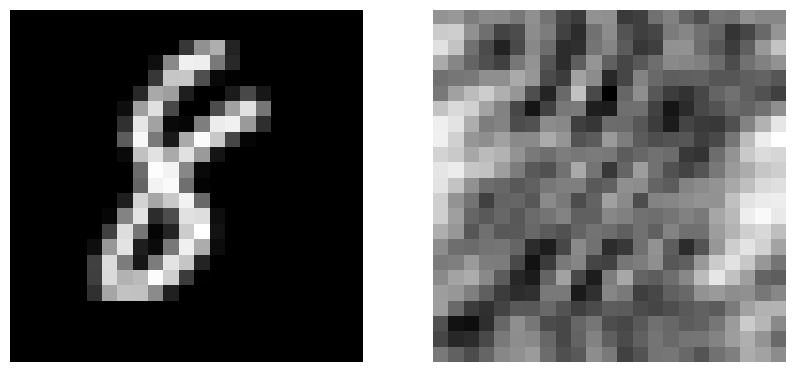

In [133]:
cmap = "gray"
index = 0
img = images[index][0]
true_img = mura.FFT_convolve(img.numpy(), G)
pred_lab = predicted[index]
true_lab = labels[index]

fig, axs = plt.subplots(1,2, figsize=(10,7))
axs = axs.ravel()

axs[0].imshow(true_img, cmap=cmap);
axs[1].imshow(img, cmap=cmap)

axs[0].axis('off') ; axs[1].axis('off')
#plt.savefig("../figs/true_img_coded_img_8.svg")
plt.show()

In [36]:
#----------------------------- PLOTTING -----------------------------
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,12],
})

FIG_FOLDER = path + f'figs/{model.params["kind"]}/{model.params["method"]}_method/'
title_size = 30
label_size = 28
tick_size = 24

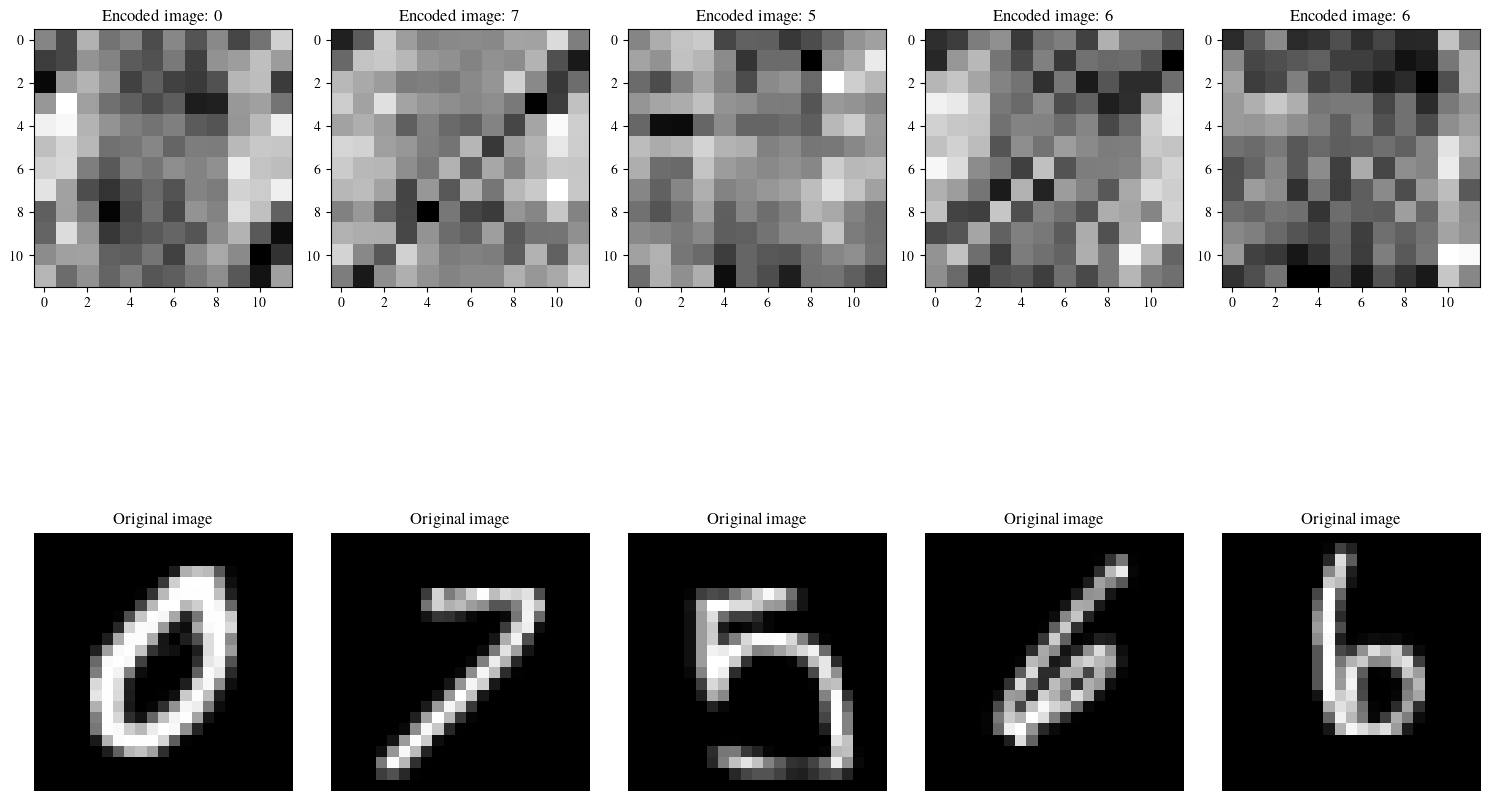

In [37]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    plt.imshow(train_data[idx][0][0].numpy(), cmap='gray')
    #plt.colorbar()
    plt.title(f'Encoded image: {train_data[idx][2]}')
    plt.subplot(2, 5, count + 6)
    plt.imshow(train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

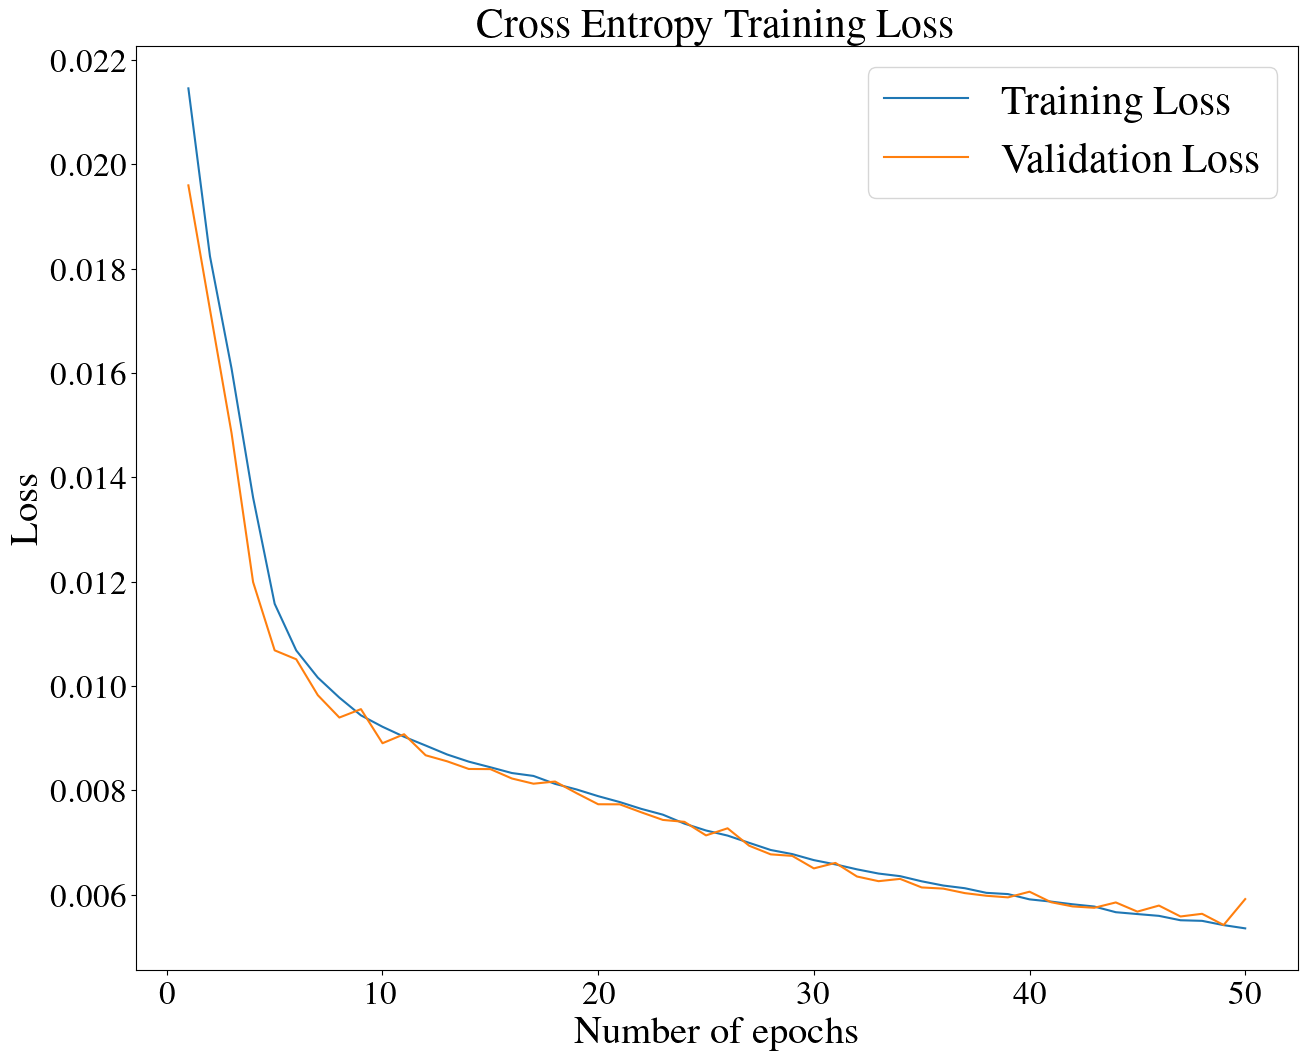

In [40]:
# --- Plot training and val loss
fig, axs = plt.subplots(1,1)
axs.plot(range(1,model.params['epochs']+1), train_loss, label="Training Loss")
axs.plot(range(1,model.params['epochs']+1), val_loss, label="Validation Loss")


axs.set_xlabel("Number of epochs", fontsize = label_size)
axs.set_ylabel("Loss", fontsize = label_size)
axs.set_title("Cross Entropy Training Loss", fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
axs.legend(fontsize=title_size)
# plt.savefig(FIG_FOLDER + f'training_loss_{model.params["model"]}.png')
plt.show()

## Confusion Matrix

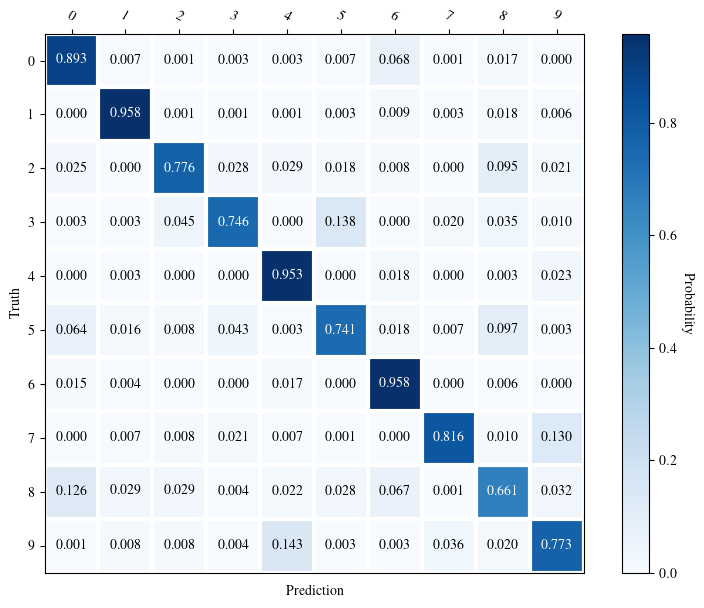

In [41]:
# --- Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
# fig1.savefig(FIG_FOLDER + f'conf_mat_{params["model"]}.png')

# Missclassifications

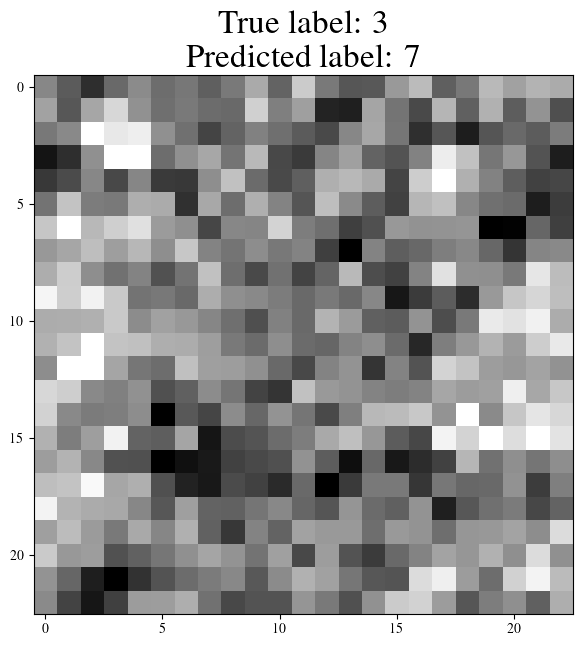

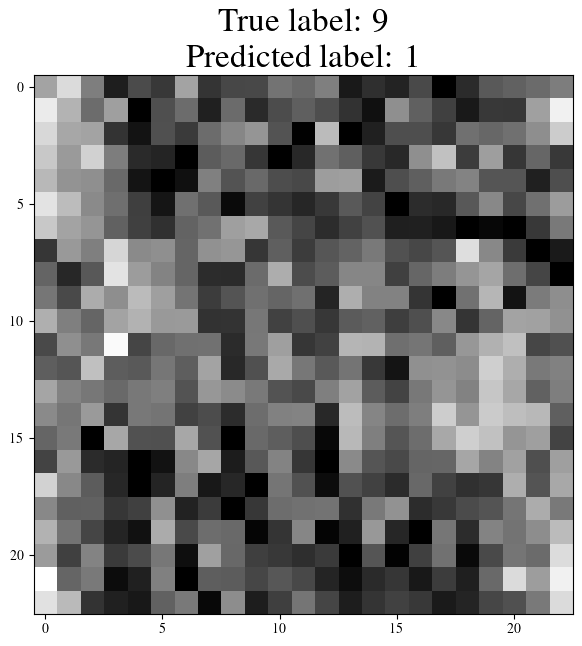

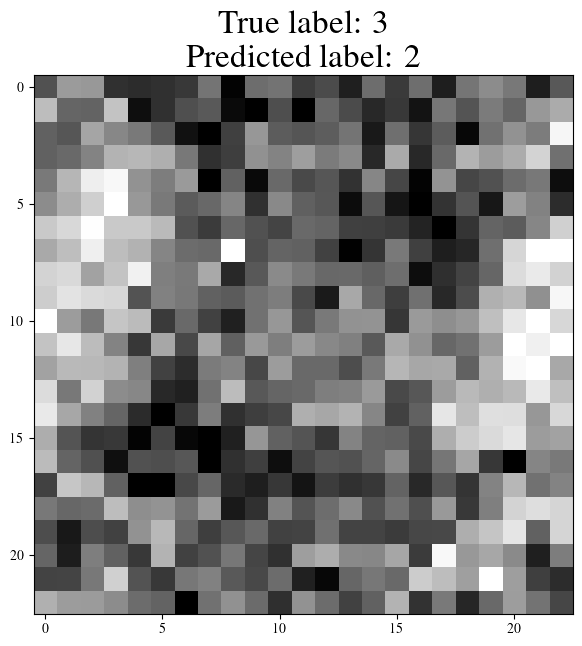

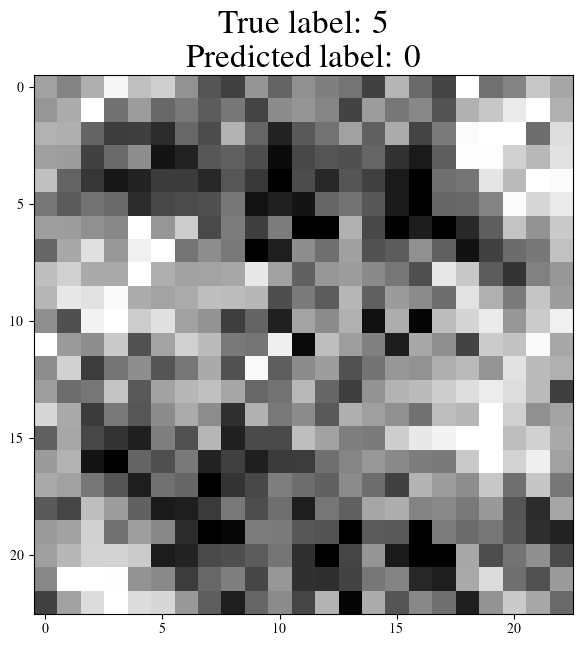

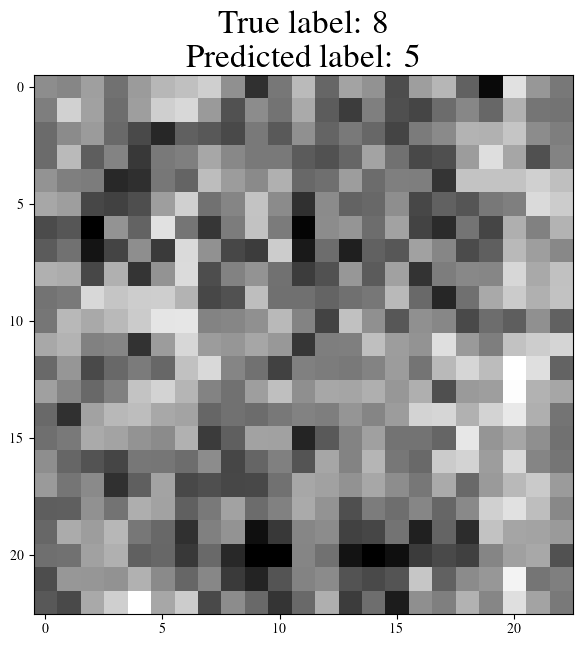

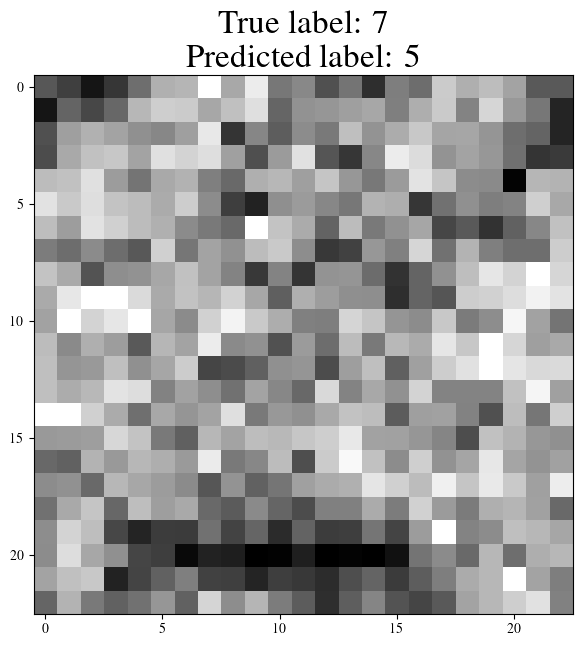

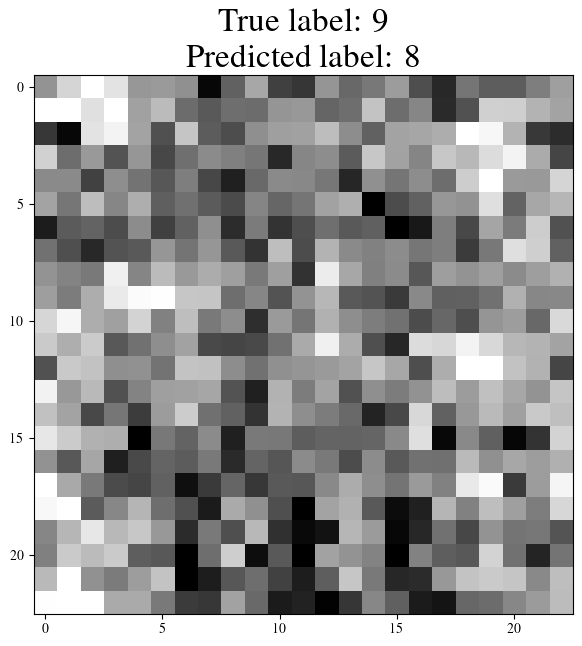

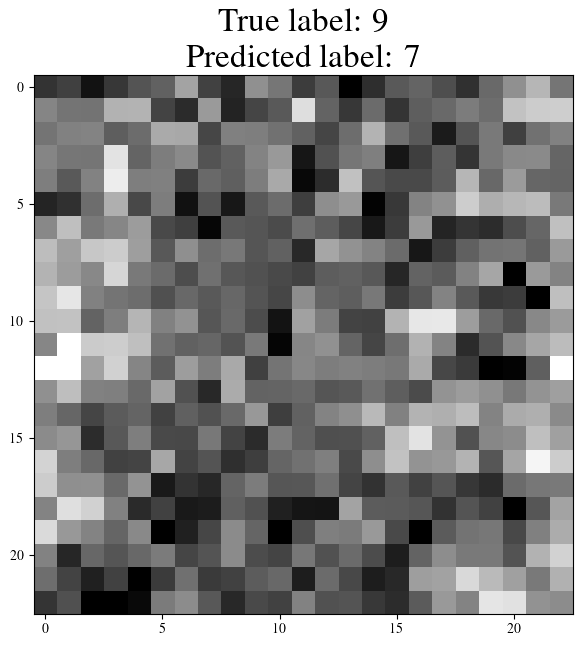

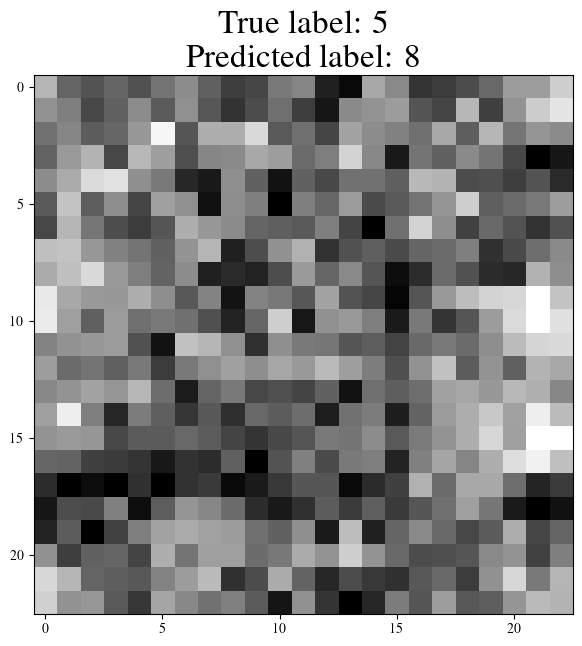

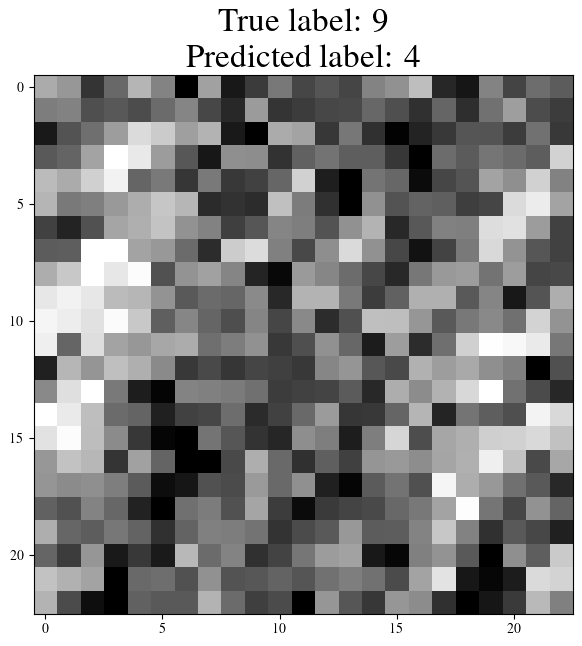

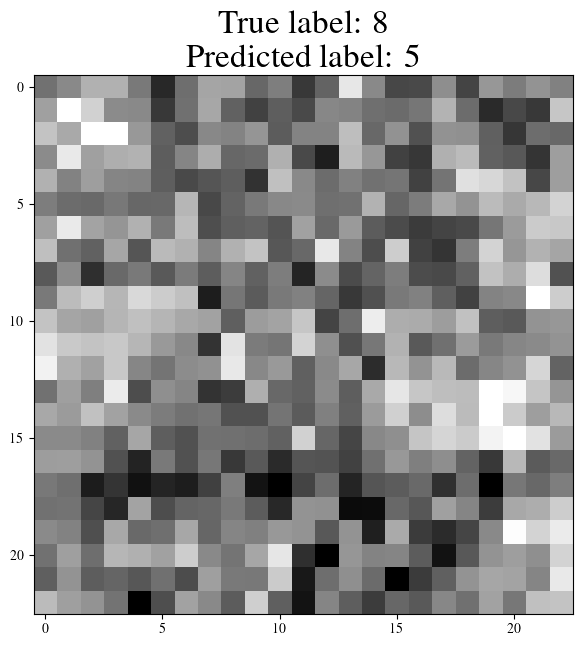

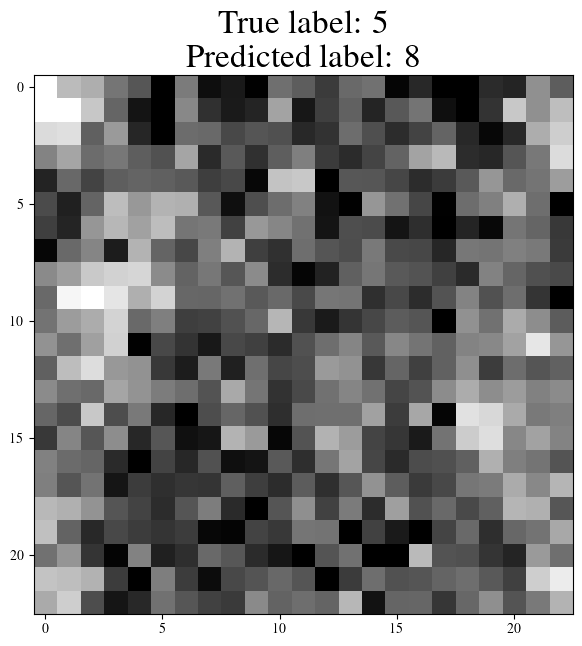

In [13]:
#index = 1
#FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"

cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    img = np.squeeze(incorrect_examples[index][0])
    #true_img = mura.FFT_convolve(img, G)
    true_lab = incorrect_examples[index][1]
    pred_lab = incorrect_examples[index][2]

    if true_lab in [5,7,3,8,9]:
        #fig, axs = plt.subplots(2,1, figsize=(5,12))
        #axs = axs.ravel()
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs[0].imshow(true_img, cmap=cmap)
        axs.imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[0].set_title(f"Original Image", fontsize=24)
        #fig.savefig(FIG_FOLDER + f'misclass_{params["model"]}_{index}.png')
        plt.show() 

Misclassifications stats
8    0.195470
3    0.147651
9    0.135906
2    0.135067
5    0.132550
7    0.111577
0    0.063758
1    0.027685
4    0.026007
6    0.024329
Name: label, dtype: float64


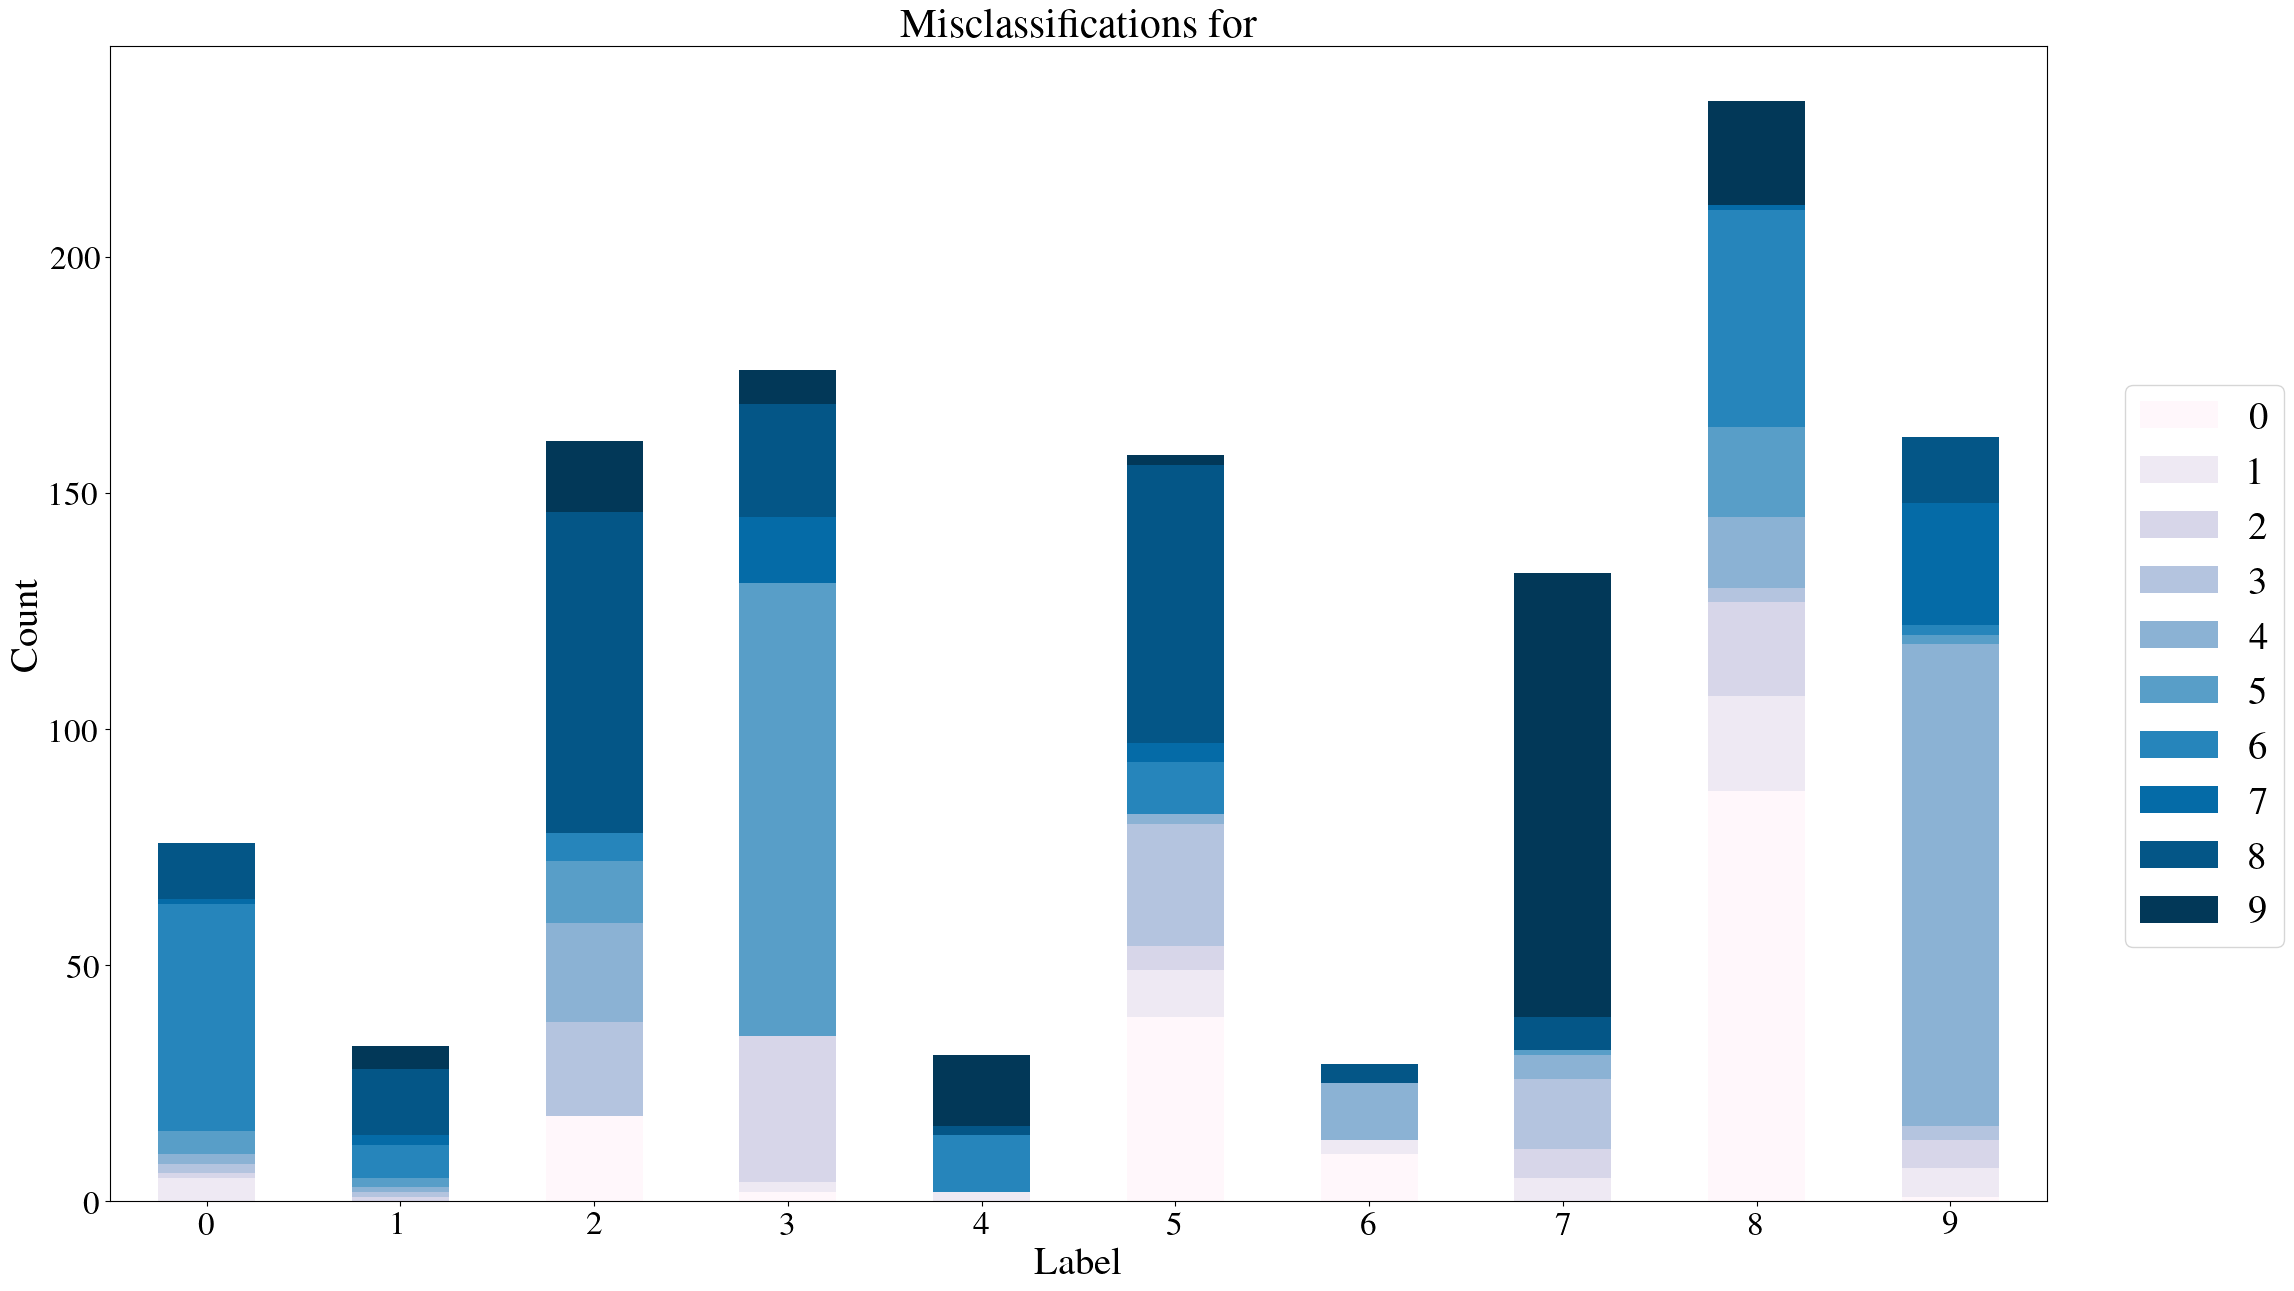

prediction   0   1   2   3    4   5   6   7   8   9
label                                              
0            0   5   1   2    2   5  48   1  12   0
1            0   0   1   1    1   2   7   2  14   5
2           18   0   0  20   21  13   6   0  68  15
3            2   2  31   0    0  96   0  14  24   7
4            0   2   0   0    0   0  12   0   2  15
5           39  10   5  26    2   0  11   4  59   2
6           10   3   0   0   12   0   0   0   4   0
7            0   5   6  15    5   1   0   0   7  94
8           87  20  20   3   15  19  46   1   0  22
9            1   6   6   3  102   2   2  26  14   0


In [44]:
# Save dataframe with misclassifications
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])
print("Misclassifications stats")
print(df.label.value_counts(normalize=True))

plt.rcParams.update({"figure.figsize" : [25,15]})
crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=label_size)
plt.xlabel("Label", fontsize=label_size)
plt.title(f"Misclassifications for ", fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.legend(fontsize=label_size,loc=(1.04, 0.22))
# plt.savefig(FIG_FOLDER + f'misclass_{params["model"]}.png')
plt.show()
print(crosstab_misclass)